In [79]:
#import libraries

import mod_5_project_helper as hp
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold, cross_validate, cross_val_predict
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import OneHotEncoder
from sklearn.tree import export_graphviz
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve, auc
from imblearn.over_sampling import SMOTE
from sklearn.metrics import roc_auc_score


#set environment - REMEMBER TO COPY OVER mod_5_project_helper.py

hp.set_environment()
%matplotlib inline
pd.set_option('display.max_columns', None)
# pd.set_option('display.max_rows', None)

#initiliase variables

%run variables.py

#import data

df = pd.read_csv("data.csv")

In [80]:
df.drop_duplicates(inplace = True) #drop 10,728 duplicate rows


In [81]:
df.drop(index = 100000, axis = 0, inplace = True) #delete last blank row in the data set

In [82]:
df.drop(df[df["Current Loan Amount"] == 99999999].index, inplace = True) #delete 11484 rows where the loan amount is 99999999

In [83]:
df.dropna(subset = ['Credit Score'], inplace = True) #delete 19154 rows where Credit Score is missing

In [84]:
df.dropna(subset = ['Years in current job'], inplace = True) #delete 2564 rows where Years in current job is missing

In [85]:
df["Years in current job"].replace(to_replace = "year.*", value = "",inplace = True, regex = True) #remove 'years' or 'year' from string

In [86]:
df.drop(df[df["Home Ownership"] == "HaveMortgage"].index, inplace = True) #delete 120 rows with "HaveMortgage" as meaning isn't clear

In [87]:
df.dropna(subset = ['Months since last delinquent'], inplace = True) #delete 30,000 rows where data is missing

In [88]:
df.drop(columns = "Maximum Open Credit", inplace = True) #delete Maximum Open Credit columns as some of these numbers are huge e.g. 798255370.0

In [89]:
df = hp.drop_column_keyword_search(df, ["Loan ID", "Customer ID"]) #delete features 'Loan ID' and 'Customer ID' as they don't add anything

In [90]:
df = df.fillna(df.median()) #fill remaining values with

In [91]:
#rename and consolidate categorical variables for purpose

df["Purpose"].replace({
              "Business Loan": "business_loan",
              "Medical Bills": "medical bills",
              "Educational Expenses": "educational_expenses",
              "Buy House": "buy_house",
              "Buy a Car": "buy_a_car",
              "Debt Consolidation": "debt_consolidation",
              "Home Improvements": "home_improvements",
              "Take a Trip": "take_a_trip",
              "vacation": "take_a_trip",
              "Major Purchase": "other",
              "Other": "other", 
              "renewable_energy": "home_improvements",
              "small_business": "business_loan",
              "moving": "home_improvements",
              "major_purchase": "major_purchase",
              "wedding": "wedding"
              }, inplace=True)

In [92]:
#rename categorical variables for Home Ownership

df["Home Ownership"].replace({
              "Home Mortgage": "mortgage",
              "Rent": "rent",
              "Own Home": "own_home",
              }, inplace=True)

In [93]:
#rename categorical variables for Term

df["Term"].replace({
              "Long Term": "long_term",
              "Short Term": "short_term",
              }, inplace=True)

In [94]:
#rename categorical variables for Loan Status

df["Loan Status"].replace({
              "Fully Paid": "fully_paid",
              "Charged Off": "default",
              }, inplace=True)

In [95]:
#rename columns to make the dataset easier to work with using . notation

df.columns = ['loan_status',
              'loan_amount',
              'term',
              'credit_score',
              'annual_income',
              'years_in_current_job',
              'home_ownership',
              'loan_purpose',
              'monthly_debt',
              'years_of_credit_history',
              'months_since_last_delinquent',
              'number_of_open_accounts',
              'number_of_credit_problems',
              'current_credit_balance',
              'bankruptcies',
              'tax_liens']


In [96]:
df.reset_index(inplace = True); #reset index
df.drop(columns = "index", inplace = True) #remove extra index columns as not needed
df['loan_status_binary_value'] = np.where(df["loan_status"] == "fully_paid",1,0) #add a binary columns for loan_status with 1 = "fully_paid" and 0 = "default"

In [97]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26401 entries, 0 to 26400
Data columns (total 17 columns):
loan_status                     26401 non-null object
loan_amount                     26401 non-null float64
term                            26401 non-null object
credit_score                    26401 non-null float64
annual_income                   26401 non-null float64
years_in_current_job            26401 non-null object
home_ownership                  26401 non-null object
loan_purpose                    26401 non-null object
monthly_debt                    26401 non-null float64
years_of_credit_history         26401 non-null float64
months_since_last_delinquent    26401 non-null float64
number_of_open_accounts         26401 non-null float64
number_of_credit_problems       26401 non-null float64
current_credit_balance          26401 non-null float64
bankruptcies                    26401 non-null float64
tax_liens                       26401 non-null float64
loan_status_bina

In [98]:
df.shape

(26401, 17)

In [99]:
df.head()

,loan_status,loan_amount,term,credit_score,annual_income,years_in_current_job,home_ownership,loan_purpose,monthly_debt,years_of_credit_history,months_since_last_delinquent,number_of_open_accounts,number_of_credit_problems,current_credit_balance,bankruptcies,tax_liens,loan_status_binary_value
0,fully_paid,217646.0,short_term,730.0,1184194.0,< 1,mortgage,debt_consolidation,10855.08,19.6,10.0,13.0,1.0,122170.0,1.0,0.0,1
1,fully_paid,548746.0,short_term,678.0,2559110.0,2,rent,debt_consolidation,18660.28,22.6,33.0,4.0,0.0,437171.0,0.0,0.0,1
2,fully_paid,234124.0,short_term,727.0,693234.0,10+,rent,debt_consolidation,14211.24,24.7,46.0,10.0,1.0,28291.0,1.0,0.0,1
3,fully_paid,666204.0,long_term,723.0,1821967.0,10+,mortgage,debt_consolidation,17612.24,22.0,34.0,15.0,0.0,813694.0,0.0,0.0,1
4,default,317108.0,long_term,687.0,1133274.0,8,rent,debt_consolidation,9632.81,17.4,53.0,4.0,0.0,60287.0,0.0,0.0,0


In [100]:
#define X and y columns

X = df.drop(columns = ["loan_status", "loan_status_binary_value"])
y = df.loan_status_binary_value

In [101]:
#define train, validation and test data 

X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=.2,random_state=42)
X_train,X_val,y_train,y_val = train_test_split(X_train,y_train,test_size=.2,random_state=42)

In [102]:
#make a dataframe of categorical variables - training data

X_train_categorical = pd.concat([X_train.term, 
                                 X_train.years_in_current_job, 
                                 X_train.home_ownership, 
                                 X_train.loan_purpose], 
                                 axis = 1)

In [103]:
#make a dataframe of continous variables - training data

X_train_continuous = pd.concat([X_train.loan_amount, 
                                X_train.credit_score, 
                                X_train.annual_income, 
                                X_train.monthly_debt, 
                                X_train.years_of_credit_history,
                                X_train.months_since_last_delinquent,
                                X_train.number_of_open_accounts,
                                X_train.current_credit_balance,
                                X_train.bankruptcies,
                                X_train.tax_liens], 
                                axis = 1)

In [104]:
#one hot encode categorical variables - training data
#for everything but decision trees we should do drop_first = True
X_train_one_hot_encoded = pd.get_dummies(X_train_categorical)

In [105]:
#stitch the one hot encoded dataframe back together - training data

X_train_all_numbers = pd.concat([X_train_continuous, X_train_one_hot_encoded], axis = 1)

In [106]:
#make a dataframe of categorical variables - validation data

X_val_categorical = pd.concat([X_val.term, 
                               X_val.years_in_current_job, 
                               X_val.home_ownership, 
                               X_val.loan_purpose], 
                               axis = 1)

In [107]:
#make a dataframe of continous variables - validation data

X_val_continuous = pd.concat([X_val.loan_amount, 
                              X_val.credit_score, 
                              X_val.annual_income, 
                              X_val.monthly_debt, 
                              X_val.years_of_credit_history,
                              X_val.months_since_last_delinquent,
                              X_val.number_of_open_accounts,
                              X_val.current_credit_balance,
                              X_val.bankruptcies,
                              X_val.tax_liens], 
                              axis = 1)

In [108]:
#one hot encode categorical variables - validation data
#for everything but decision trees we should do drop_first = True
X_val_one_hot_encoded = pd.get_dummies(X_val_categorical)

In [109]:
#stitch the one hot encoded dataframe back together - validation data

X_val_all_numbers = pd.concat([X_val_continuous, X_val_one_hot_encoded], axis = 1)

In [110]:
#use SMOTE to resample training data

smote = SMOTE()
X_train_resampled, y_train_resampled = smote.fit_sample(X_train_all_numbers, y_train)

In [111]:
crossvalidation = KFold(n_splits=10, shuffle=True, random_state=42) #initialise cross validation object
crossvalidation

KFold(n_splits=10, random_state=42, shuffle=True)

In [112]:
#export data for CSVs for ease

X_train_resampled.to_csv("X_train.csv")
X_val_all_numbers.to_csv("X_val.csv")
y_train_resampled.to_csv("y_train.csv")
y_val.to_csv("y_val.csv")

## Log Reg

In [113]:
from sklearn.linear_model import LogisticRegression


In [114]:
log_reg = LogisticRegression()
log_reg.fit(X_train_all_numbers, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [115]:
y_predicted = log_reg.predict(X_train_all_numbers)

In [116]:
from sklearn.metrics import accuracy_score
accuracy_score(y_train, y_predicted)

0.7827296401515151

In [117]:
from sklearn.metrics import confusion_matrix
confusion_matrix(y_train, y_predicted)

array([[ 1340,  3524],
       [  147, 11885]])

In [118]:
y_hat_train = log_reg.predict(X_train_all_numbers)
y_hat_test = log_reg.predict(X_val_all_numbers)


from sklearn.metrics import precision_score, recall_score, accuracy_score, f1_score

print('\nTraining Precision: ', precision_score(y_train, y_hat_train))
print('Testing Precision: ', precision_score(y_val, y_hat_test))
print('\n')

print('Training Recall: ', recall_score(y_train, y_hat_train))
print('Testing Recall: ', recall_score(y_val, y_hat_test))
print('\n')

print('Training Accuracy: ', accuracy_score(y_train, y_hat_train))
print('Testing Accuracy: ', accuracy_score(y_val, y_hat_test))
print('\n')

print('Training F1-Score: ', f1_score(y_train, y_hat_train))
print('Testing F1-Score: ', f1_score(y_val, y_hat_test))


Training Precision:  0.7713024855603868
Testing Precision:  0.7789473684210526


Training Recall:  0.987782579787234
Testing Recall:  0.9898858075040783


Training Accuracy:  0.7827296401515151
Testing Accuracy:  0.7888257575757576


Training F1-Score:  0.8662220764549398
Testing F1-Score:  0.8718390804597701


In [119]:
from sklearn.metrics import roc_curve, auc

In [120]:
y_score = log_reg.fit(X_train_all_numbers, y_train).decision_function(X_val_all_numbers)

fpr, tpr, thresholds = roc_curve(y_val, y_score)

In [121]:
print('AUC: {}'.format(auc(fpr, tpr)))

AUC: 0.6597837760233762


In [122]:
def scores(model,X_train,X_val,y_train,y_val):
    train_prob = model.predict_proba(X_train)[:,1]
    val_prob = model.predict_proba(X_val)[:,1]
    train = roc_auc_score(y_train,train_prob)
    val = roc_auc_score(y_val,val_prob)
    print('train:',round(train,2),'test:',round(val,2))

In [123]:
def roc_plot(model,X_train,y_train,X_val,y_val):
    train_prob = model.predict_proba(X_train)[:,1]
    val_prob = model.predict_proba(X_val)[:,1]
    plt.figure(figsize=(7,7))
    for data in [[y_train, train_prob],[y_val, val_prob]]: # ,[y_test, test_prob]
        fpr, tpr, threshold = roc_curve(data[0], data[1])
        plt.plot(fpr, tpr)
    annot(fpr, tpr, threshold)
    plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
    plt.ylabel('TPR (power)')
    plt.xlabel('FPR (alpha)')
    plt.legend(['train','val'])
    plt.show()

In [124]:
def annot(fpr,tpr,thr):
    k=0
    for i,j in zip(fpr,tpr):
        if k %50 == 0:
            plt.annotate(round(thr[k],2),xy=(i,j), textcoords='data')
        k+=1

train: 0.71 test: 0.66


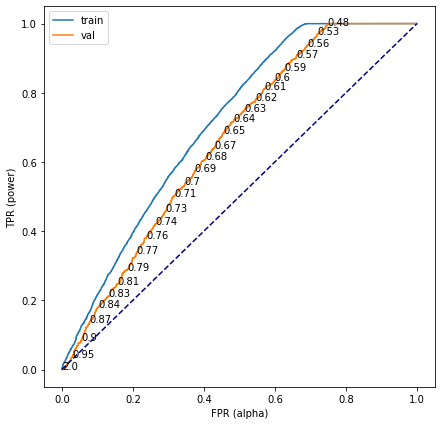

In [125]:
scores(log_reg,X_train_resampled,X_val_all_numbers,y_train_resampled,y_val)
roc_plot(log_reg,X_train_resampled,y_train_resampled,X_val_all_numbers,y_val)

In [126]:
from sklearn.model_selection import GridSearchCV

In [127]:
opt_log = LogisticRegression(random_state = 42)

penalty = ['l1', 'l2']
C = [0.001,0.01,0.1,1,10,100,1000]

hyperparameters = dict(C=C, penalty=penalty)

#param_grid = {'max_depth':range(10,50,10),'min_samples_leaf':[5,50,500]}

opt_model = GridSearchCV(opt_log,hyperparameters,cv=crossvalidation,scoring='roc_auc',return_train_score=True,n_jobs=-1)
opt_model.fit(X_train_all_numbers,y_train)
best_model = opt_model.best_estimator_

scores(best_model,X_train_all_numbers,X_val_all_numbers,y_train,y_val)
print(opt_model.best_params_)
#opt_plots(opt_model)

train: 0.68 test: 0.66
{'C': 10, 'penalty': 'l2'}


train: 0.68 test: 0.66


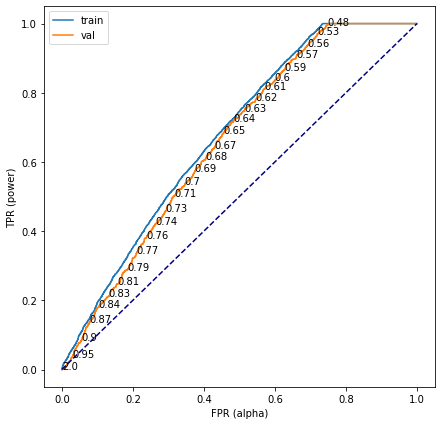

In [128]:
scores(best_model,X_train_all_numbers,X_val_all_numbers,y_train,y_val)
roc_plot(best_model,X_train_all_numbers,y_train,X_val_all_numbers,y_val)

In [129]:
opt_log = LogisticRegression(random_state = 42)

penalty = ['l1', 'l2']
C = [4,5,6,7,8,9,10,11,20]

hyperparameters = dict(C=C, penalty=penalty)

opt_model = GridSearchCV(opt_log,hyperparameters,cv=crossvalidation,scoring='roc_auc',return_train_score=True,n_jobs=-1)
opt_model.fit(X_train_all_numbers,y_train)
best_model = opt_model.best_estimator_

scores(best_model,X_train_all_numbers,X_val_all_numbers,y_train,y_val)
print(opt_model.best_params_)
#opt_plots(opt_model)

train: 0.68 test: 0.66
{'C': 6, 'penalty': 'l2'}


train: 0.68 test: 0.66


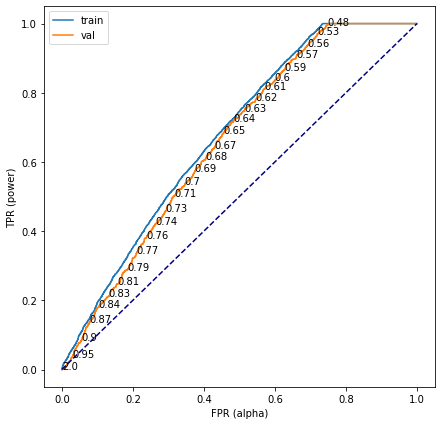

In [130]:
scores(best_model,X_train_all_numbers,X_val_all_numbers,y_train,y_val)
roc_plot(best_model,X_train_all_numbers,y_train,X_val_all_numbers,y_val)

## THE END

In [131]:
#from sklearn.model_selection import GridSearchCV

In [132]:
#penalty = ['l1', 'l2']

In [133]:
#C = [0.001,0.01,0.1,1,10,100,1000]

In [134]:
#hyperparameters = dict(C=C, penalty=penalty)

In [135]:
#clf = GridSearchCV(log_reg, hyperparameters, cv=crossvalidation)

In [136]:
#best_model = clf.fit(X_train_all_numbers, y_train)

In [137]:
#print('Best Penalty:', best_model.best_estimator_.get_params()['penalty'])
#print('Best C:', best_model.best_estimator_.get_params()['C'])

In [138]:
#log_reg = LogisticRegression(C=0.001)
#log_reg.fit(X_train_all_numbers, y_train)
#y_predicted = log_reg.predict(X_val_all_numbers)
#accuracy_score(y_val, y_predicted)